# imports

# input data

In [2]:
# funtions to preprocess data
def mapping_2_df(actual_df,predicted_df,hit_threadhold = 0.5):
    result = pd.merge(actual_df,predicted_df, on=['video_id','action_id'],how='left',suffixes=('_g', '_p'))
    result['diff_start'] = abs(result['start_g']-result['start_p'])
    result['diff_end'] = abs(result['end_g']-result['end_p'])
    # filter out condition
    result['is_filtered'] = (result['diff_start'] >10) | (result['diff_end']>10)
    # calculate intersection time
    result['i_start'] = np.where(~result['is_filtered'], result[['start_g', 'start_p']].max(axis=1), np.nan)
    result['i_end'] = np.where(~result['is_filtered'], result[['end_g', 'end_p']].min(axis=1), np.nan)
    # calculate union time
    result['u_start'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['start_g', 'start_p']].min(axis=1), np.nan)
    result['u_end'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['end_g', 'end_p']].max(axis=1), np.nan)
    # calculate IoU
    result['intersection'] = result['i_end'] - result['i_start']
    result['union'] = result['u_end'] - result['u_start']
    result['iou'] = np.where(~result['is_filtered'] 
                             & result['union']>0,result['intersection']/result['union'],0)
    # flag hit base on threadhold
    result['is_hit'] = np.where(result['iou'] >= hit_threadhold,1,0)
    return result





In [3]:
# mapping df base on video_id and start
def mapping_2_df_by_time(actual_df,predicted_df,hit_threadhold = 0.5,time_threadhold = 10):
    '''
        mapping 2 df by video_id
            after that, add filter column with gap 10s from the contest
            calculate iou
            remap with actual_df for confusion_matrix
            relabel
        
    '''
    result = pd.merge(actual_df,predicted_df, on=['video_id'],how='left',suffixes=('_g', '_p'))
    result['diff_start'] = abs(result['start_g']-result['start_p'])
    result['diff_end'] = abs(result['end_g']-result['end_p'])

    # filter out condition
    result['is_filtered'] = (result['diff_start'] >time_threadhold) | (result['diff_end']>time_threadhold)
    result = result.loc[~result['is_filtered']]

    # calculate intersection time
    result['i_start'] = np.where(~result['is_filtered'], result[['start_g', 'start_p']].max(axis=1), np.nan)
    result['i_end'] = np.where(~result['is_filtered'], result[['end_g', 'end_p']].min(axis=1), np.nan)

    # calculate union time
    result['u_start'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['start_g', 'start_p']].min(axis=1), np.nan)
    result['u_end'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['end_g', 'end_p']].max(axis=1), np.nan)
    # calculate IoU
    result['intersection'] = result['i_end'] - result['i_start']
    result['union'] = result['u_end'] - result['u_start']
    result['iou'] = np.where(~result['is_filtered'] 
                             & result['union']>0,result['intersection']/result['union'],0)
    
    # flag hit base on threadhold
    result['is_hit'] = np.where(result['iou'] >= hit_threadhold,1,0)
    result = result.sort_values(['iou'],ascending=False).drop_duplicates(['video_id','action_id_p'])
    # result = result.loc[result['is_hit']==1]

    # remap with actual df
    temp = actual_df[['video_id','action_id']]\
            .merge(
                result[['video_id','action_id_g','action_id_p','iou']]                    
                ,left_on =['video_id','action_id']
                ,right_on=['video_id','action_id_g']
                ,how='left'
                ,suffixes=('_g', '_p'))
    temp['action_id_p'] = temp['action_id_p'].fillna(-1)
    action_label = pd.read_csv("data/Distracted_Activity_Class_definition.txt",sep=',')

    action_id_to_label = action_label.set_index('action_id')['Label'].to_dict()
    # display(action_label)
    # Map action_ids to labels in the DataFrame
    temp['action_label_g'] = temp['action_id'].map(action_id_to_label)
    temp['action_label_p'] = temp['action_id_p'].map(action_id_to_label)
    temp['action_label_g'] = temp['action_label_g'].fillna("-1")
    temp['action_label_p'] = temp['action_label_p'].fillna("-1")
    temp['iou'] = temp['iou'].fillna(0)
    return temp



# calculate and plot the confustion matrix

In [4]:


def cal_cm(y_true, y_pred):
    # add unreconized label 
    unique_labels = np.append(y_true.unique(), "-1")
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    # Convert to DataFrame for easier plotting
    # pd_df of indexes for columns and labels
    cm_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

    return cm_df

def plot_confusion_matrices(confusion_matrices_dict, size=25, transpose=False):
    
    fortmat_code = {'cm_count':'d','cm_iou':'.2f','action_iou':'.2f','cm_sum_iou':'.2f','action_sum_iou':'.2f'}
    num_matrices = len(confusion_matrices_dict)
    # Extracting the keys from the dictionary and getting the number of metrics
    metrics = list(confusion_matrices_dict.values())[0].keys()
    num_metrics = len(metrics)
    print(f"Ploting {metrics} metrics x {num_matrices} matrixes, transpose = {transpose}")
    # Create a figure with subplots based on the number of confusion matrices
    if transpose:
        fig, axes = plt.subplots(num_metrics, num_matrices, figsize=(size * num_matrices+5, size * num_metrics+5), squeeze=False)
    else:
        fig, axes = plt.subplots(num_matrices, num_metrics, figsize=(size * num_metrics+5, size * num_matrices+5), squeeze=False)

    # Plot each confusion matrix
    for i, (title, metric_dict) in enumerate(confusion_matrices_dict.items()):
        for j, (metric_name, cm_df) in enumerate(metric_dict.items()):
            cm_df.sort_index(axis=0, inplace=True)
            cm_df.sort_index(axis=1, inplace=True)
            if transpose:
                ax = axes[j, i]
            else:
                ax = axes[i, j]
            sns.heatmap(cm_df, annot=True, ax=ax, fmt=fortmat_code[metric_name], cmap='Blues',
                        xticklabels=cm_df.columns, yticklabels=cm_df.index,cbar=False)
            ax.set_title(f"{title} - {metric_name}",fontsize=size*1.5,fontweight='bold',color='blue')
            ax.set_ylabel('True label',fontsize=size,fontweight='bold')
            ax.set_xlabel('Predicted label',fontsize=size,fontweight='bold')
            ax.tick_params(axis='x', labelsize=size*0.7,rotation=60)
            ax.tick_params(axis='y', labelsize=size*0.7,rotation=0)
            ax.set_aspect('equal') 
    # Show the plot
    plt.show()



def benchmark_submit(df_ground_truth, csv_file_path = 'A2_submission_old.txt'):
    print("*"*100)
    print(csv_file_path)
    print("*"*100)
    df_baseline = pd.read_csv(csv_file_path,sep=' ')
    df_baseline.columns = ['video_id', 'action_id','start','end']

    print("calculated result vs ground truth:") 
    preprocess = mapping_2_df(df_ground_truth,df_baseline)
    # display(preprocess)
    print("avg iou with correct action_id: ",preprocess['iou'].mean())
    print(f"hit = {preprocess['is_hit'].sum()} | count = {preprocess['is_hit'].count()} | hit/count = {preprocess['is_hit'].sum()/preprocess['is_hit'].count()}")
    action_label = pd.read_csv("data/Distracted_Activity_Class_definition.txt",sep=',')
    action_id_to_label = action_label.set_index('action_id')['Label'].to_dict()
    preprocess['action_label'] = preprocess['action_id'].map(action_id_to_label)
    display(pd.pivot_table(preprocess,values='iou',columns='action_label',aggfunc='mean',fill_value=0))
    print("Creating confusion matrix")
    test = mapping_2_df_by_time(df_ground_truth,df_baseline)
    # print(test.groupby('video_id').nunique())
    # display(test)
    result = {}
    
    result['cm_count'] = cal_cm(test['action_label_g'],test['action_label_p'])
    # result['iou'] = test['iou']

    # calculate avg_iou
    result['cm_iou'] = pd.pivot_table(test,values='iou',index='action_label_g',columns='action_label_p',aggfunc='mean',fill_value=0)
    # Create a new DataFrame for the row to be added
    new_row = pd.DataFrame(data={col: [0] for col in result['cm_iou'].columns}, index=['-1'])
    # Append the new row to the pivot table
    result['cm_iou'] = pd.concat([result['cm_iou'], new_row])

    # calculate sum iou
    result['cm_sum_iou'] = pd.pivot_table(test,values='iou',index='action_label_g',columns='action_label_p',aggfunc='sum',fill_value=0)
    # Create a new DataFrame for the row to be added
    new_row = pd.DataFrame(data={col: [0] for col in result['cm_sum_iou'].columns}, index=['-1'])
    # Append the new row to the pivot table
    result['cm_sum_iou'] = pd.concat([result['cm_sum_iou'], new_row])




    # overall action recognigtion iou (only consider correct action)
    result['action_iou'] = pd.pivot_table(preprocess[preprocess['is_hit']==1],values='iou',index='action_label',aggfunc='mean',fill_value=0)
    result['action_sum_iou'] = pd.pivot_table(preprocess[preprocess['is_hit']==1],values='iou',index='action_label',aggfunc='sum',fill_value=0)
    print('Done')
    return result

****************************************************************************************************
A2_submission_baseline_test.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.7014440212099974
hit = 128 | count = 150 | hit/count = 0.8533333333333334


action_label,01_,02_,03_,04_,05_,06_,07_,08_,09_,10_,11_,12_,13_,14_,15_
iou,0.690635,0.684979,0.859458,0.599342,0.713322,0.77861,0.77938,0.739402,0.643561,0.777143,0.617078,0.52095,0.47177,0.841715,0.804316


Creating confusion matrix
Done
****************************************************************************************************
A2_submission_baseline_right.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.6942263566691271
hit = 121 | count = 150 | hit/count = 0.8066666666666666


action_label,01_,02_,03_,04_,05_,06_,07_,08_,09_,10_,11_,12_,13_,14_,15_
iou,0.701111,0.68741,0.763247,0.484776,0.716785,0.9,1.0,0.7,0.666012,0.755476,0.637467,0.445787,0.57903,0.581306,0.794987


Creating confusion matrix
Done
****************************************************************************************************
A2_submission_baseline_dash.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.6562209173359115
hit = 119 | count = 150 | hit/count = 0.7933333333333333


action_label,01_,02_,03_,04_,05_,06_,07_,08_,09_,10_,11_,12_,13_,14_,15_
iou,0.730902,0.65298,0.854721,0.451818,0.622062,0.711726,0.693056,0.75392,0.587132,0.707824,0.524536,0.503007,0.531008,0.768037,0.750583


Creating confusion matrix
Done
****************************************************************************************************
A2_submission_baseline_rear.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.6951013031670837
hit = 125 | count = 150 | hit/count = 0.8333333333333334


action_label,01_,02_,03_,04_,05_,06_,07_,08_,09_,10_,11_,12_,13_,14_,15_
iou,0.730664,0.699146,0.848528,0.593267,0.714399,0.759599,0.711203,0.753506,0.467623,0.7175,0.643571,0.662696,0.608302,0.837868,0.678646


Creating confusion matrix
Done
Ploting dict_keys(['cm_count', 'cm_iou', 'cm_sum_iou', 'action_iou', 'action_sum_iou']) metrics x 4 matrixes, transpose = True


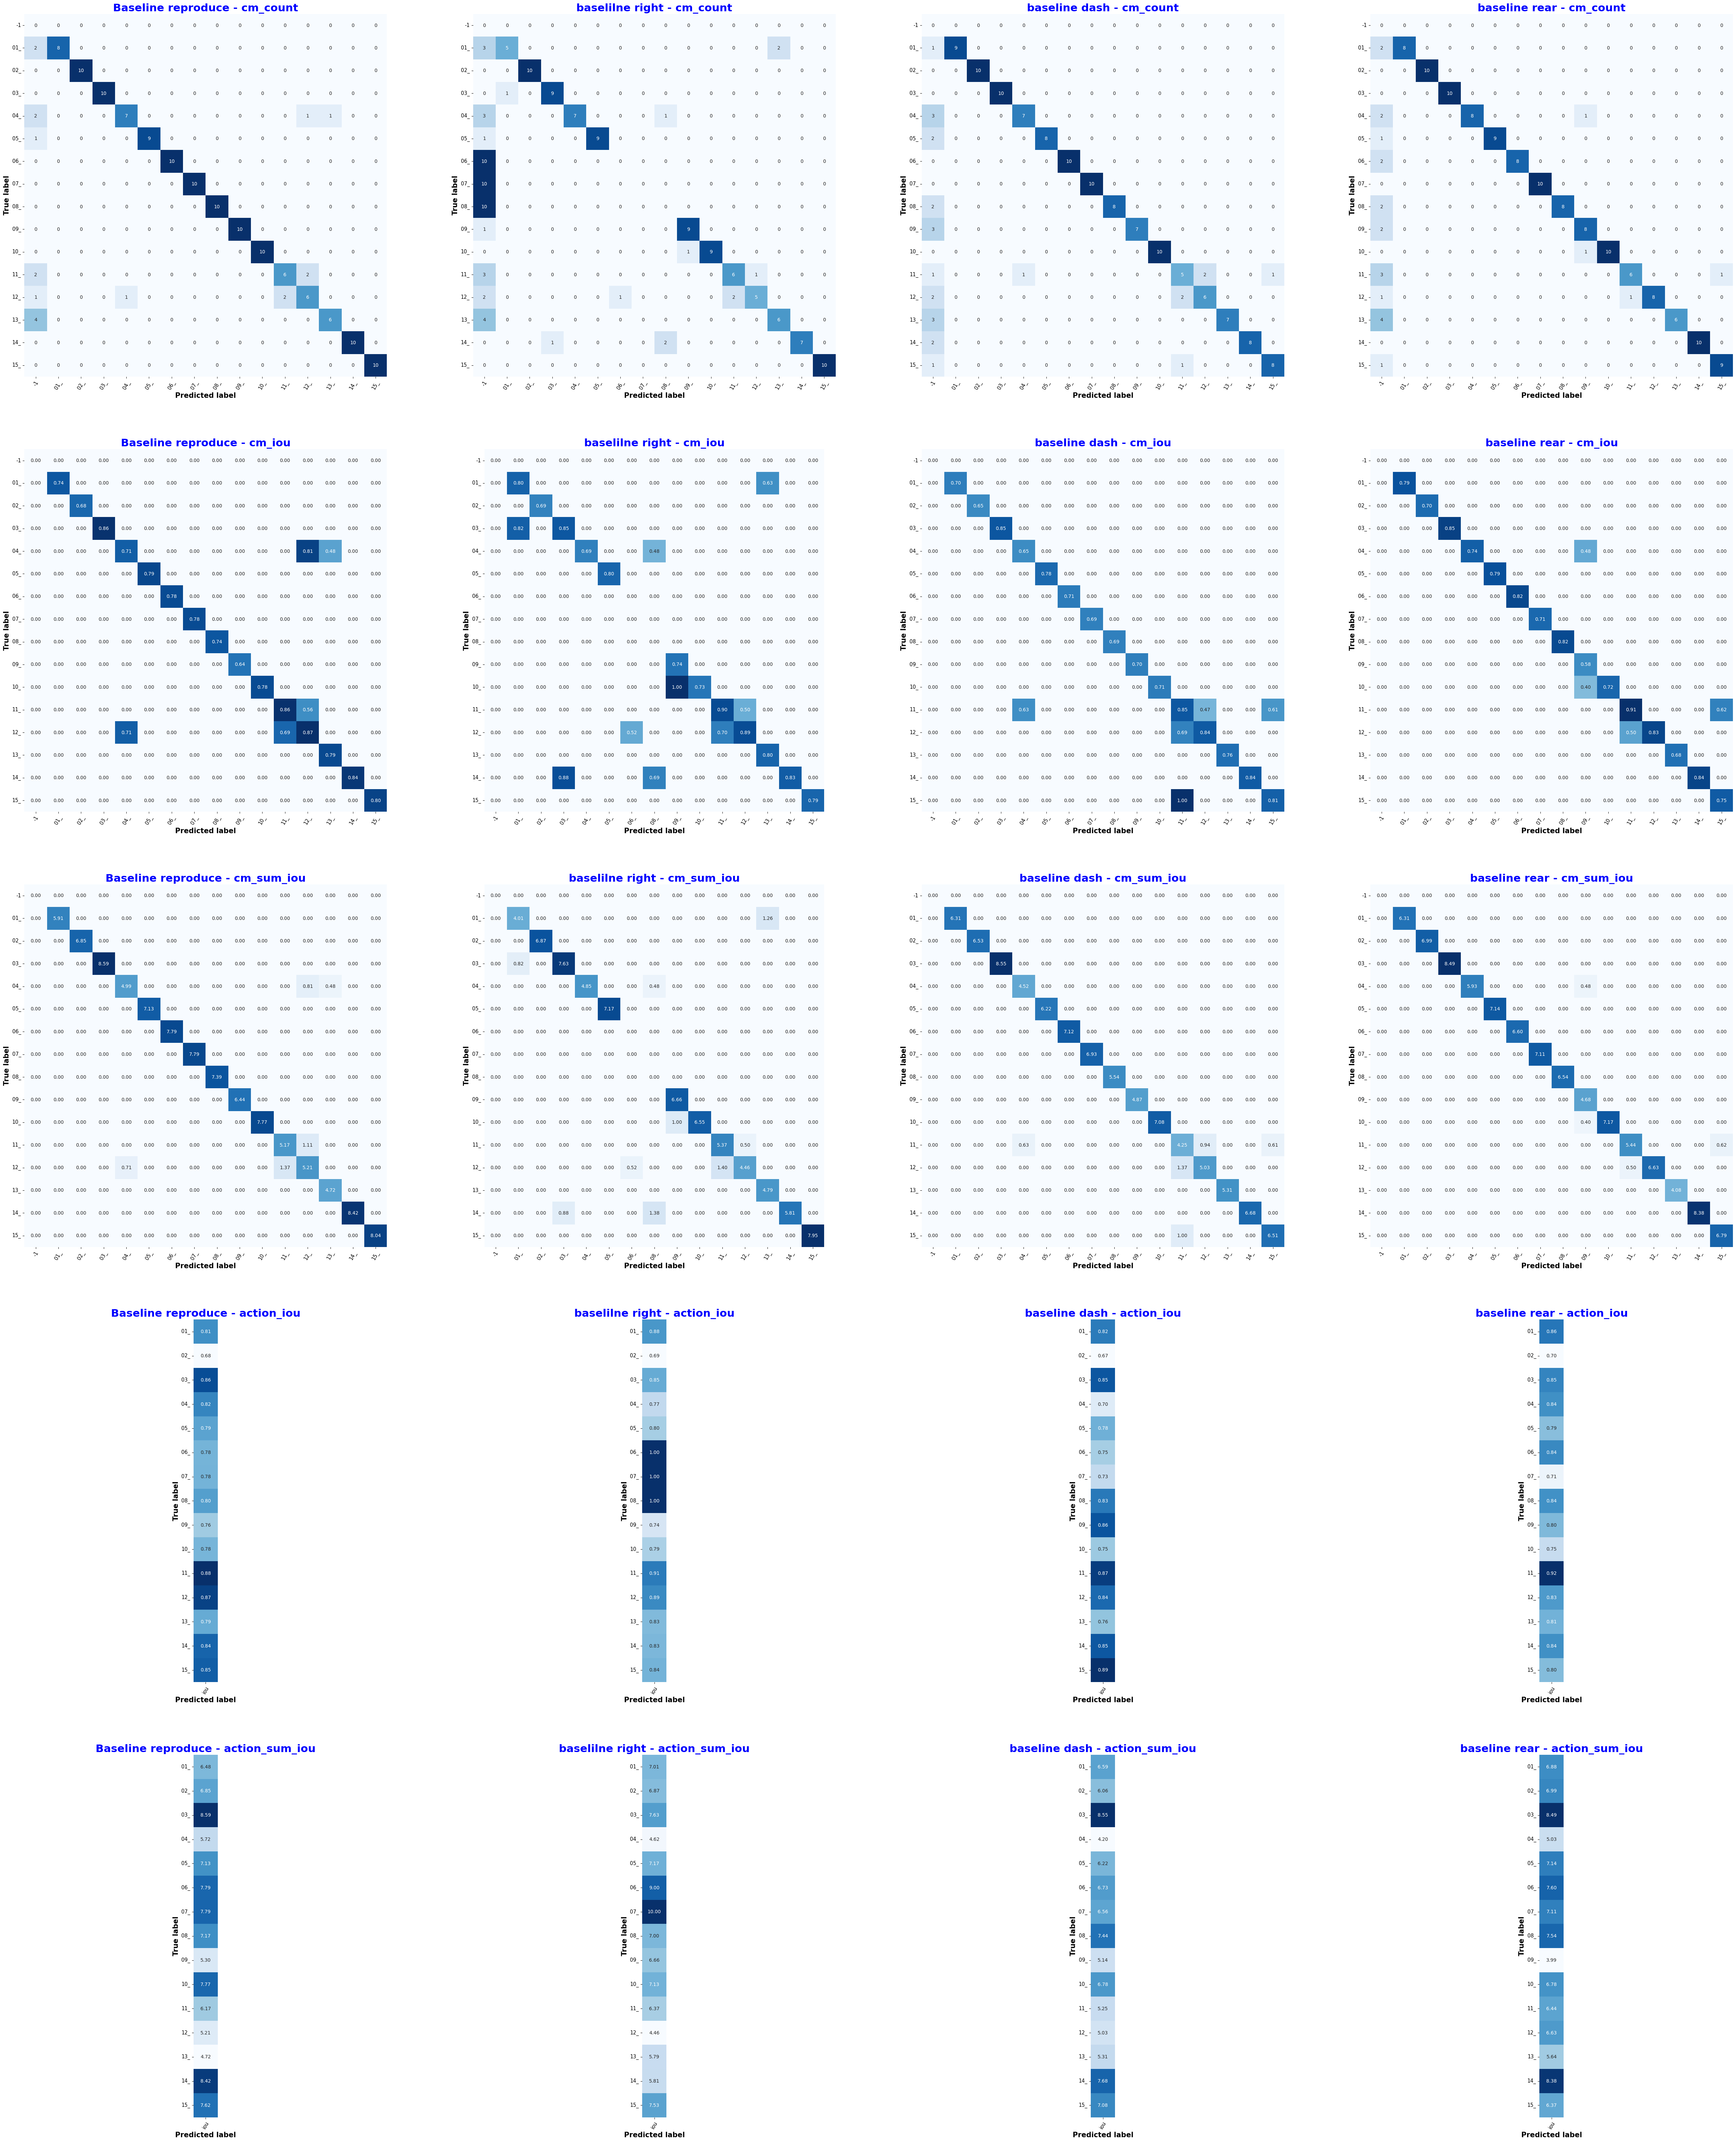

In [5]:
import warnings
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import numpy as np
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
    
# Load ground truth from Excel file
excel_file_path = 'data/A2/ground_truth_A2_manual_.xlsx'
df_ground_truth = pd.read_excel(excel_file_path,sheet_name='ground_truth_submit')

confusion_matrices_dict = {
    # '2023 1st prized': benchmark_submit(df_ground_truth,'final_submission.txt'),
    # '2023 1st prized wo buffer' : benchmark_submit(df_ground_truth,'final_submission_wo_buffer.txt'),
    # '2023 1st prized less right' : benchmark_submit(df_ground_truth,'final_submission_less_right.txt'),
    'Baseline reproduce': benchmark_submit(df_ground_truth,'A2_submission_baseline_test.txt'),
    # 'Baseline reproduce wo buffer': benchmark_submit(df_ground_truth,'A2_submission_wo_buffer.txt'),
    # 'Baseline reproduce wo buffer max': benchmark_submit(df_ground_truth,'A2_submission_wo_buffer_max.txt'),
    # 'Baseline reproduce max': benchmark_submit(df_ground_truth,'A2_submission_max.txt'),
    # 'Baseline reproduce less right': benchmark_submit(df_ground_truth,'A2_submission_test_less_right.txt'),
    # 'Baseline reproduce all avg': benchmark_submit(df_ground_truth,'A2_submission_all_avg.txt'),
    # 'Baseline reproduce all avg wo buffer': benchmark_submit(df_ground_truth,'A2_submission_all_avg_wo_buffer.txt')
    # '2023 1st prized right': benchmark_submit(df_ground_truth,'final_submission_right.txt'),
    # '2023 1st prized dash': benchmark_submit(df_ground_truth,'final_submission_dash.txt'),
    # '2023 1st prized rear': benchmark_submit(df_ground_truth,'final_submission_rear.txt'),
    'baselilne right' : benchmark_submit(df_ground_truth,'A2_submission_baseline_right.txt'),
    'baseline dash' : benchmark_submit(df_ground_truth,'A2_submission_baseline_dash.txt'),
    'baseline rear' : benchmark_submit(df_ground_truth,'A2_submission_baseline_rear.txt')
    
}
# Plot the confusion matrices
plot_confusion_matrices(confusion_matrices_dict, size = 15,transpose=True)

In [23]:
# Read result from pickle files 
# avg all the result group by video id, view
import pickle
import os
from pprint import pprint
from run_submission_modify import smoothing,_FILENAME_TO_ID,activity_localization
from tools.util_loc import clip_to_segment,correct_with_prior_constraints
from tools.util_vis import plot_probs,vis_loc_result
def load_k_fold_probs(pickle_dir, view, k=5,pickle_prefix = 'A1'):

    probs = []
    for i in range(k):
        with open(os.path.join(pickle_dir, "{}_{}_vmae_16x4_crop_fold_{}.pkl".format(pickle_prefix,view, i)), "rb") as fp:
            vmae_16x4_probs = pickle.load(fp)
        probs.append(vmae_16x4_probs)
    return probs
def print_ndarray_structure(array):
    if isinstance(array, np.ndarray):
        print("Shape:", array.shape)
        print("Data type:", array.dtype)
        print("Size:", array.size)
        print("Number of dimensions:", array.ndim)
        print("Item size:", array.itemsize)
        print("Data:", array.data)
        print("Flags:", array.flags)
    else:
        print("The input is not a NumPy ndarray.")
results = {}

def predic_by_single_view(pickle_dir,view,output_name,folds = 5,pickle_prefix ='A1'):
    clip_classification = []
    '''
        load_k_fold_probs output format:

        probs of action (16 actions) for each seconds of each videos
        [fold: {
            filename: [
                        seconds:[
                                prob of actions 1,
                                prob of action 2,
                                ...
                                prob of action 16
                            ]
            ]
        }
        ]
    '''
    k_fold_probs = load_k_fold_probs(pickle_dir, view,k = folds,pickle_prefix = pickle_prefix)
    
    vids = k_fold_probs[0].keys()
    for vid in vids:
        # print(vid)
        # 1. probs by fold
        all_probs = np.stack([np.array(list(map(np.array, view_prob[vid]))) for view_prob in k_fold_probs])    
        # pprint(all_probs.shape)
        '''
            [
                fold
                    [
                        seconds: [
                                prob of actions 1,
                                prob of action 2,
                                ...
                                prob of action 16
                        ]
                    ]
            ]

        '''
        # 2. avg by fold 
        avg_seq = np.mean(all_probs, axis=0)
        # avg_seq = smoothing(np.array(avg_seq), k=1)
        vid_id = _FILENAME_TO_ID[vid]

        prob_seq = np.squeeze(avg_seq)
        '''
        [
            seconds: [
                    prob of actions 1,
                    prob of action 2,
                    ...
                    prob of action 16
            ]
        ]
        '''
        # plot_probs(prob_seq,vid_id)
        # 3. filter out activity with max probs below threadhold
        # 4. returned  
        ''' 
            returned clip_classification:
                [
                    video_id,
                    action_idx at activity aboved thread hold,
                    start: start second,
                    end: start +1
                ]
        '''
        clip_classification += activity_localization(prob_seq, vid_id, 0.1)
        
        

    clip_classification = pd.DataFrame(clip_classification, columns=["video_id", "label", "start", "end"])
    loc_segments = clip_to_segment(clip_classification)
    # print(loc_segments.shape)
    # loc_segments = correct_with_prior_constraints(loc_segments)
    # print(len(loc_segments),"x",len(loc_segments[0]))
    results[output_name] = pd.DataFrame(loc_segments)
    with open(output_name, "w") as fp:
        for (vid, label, start, end) in loc_segments.values.tolist():
            fp.writelines("{} {} {} {}\n".format(int(vid), label, start, end))   
        
pickle_dir = "pickles/author"
# predic_by_single_view(pickle_dir,'dash',"dash.txt")
# display(results['dash.txt'])

views = ['dash','right','rear']
outputs = [f'final_no_post_{view}.txt' for view in views]
# confusion_matrices_dict = {"after postprocessing":benchmark_submit(df_ground_truth,"final_submission.txt")}
confusion_matrices_dict = {}

# for plotting folds 
# for i in range(len(outputs)):
#     for k in range(1,6,1):
#         print(f'avg total fold: {k}')
#         predic_by_single_view(pickle_dir=pickle_dir,view=views[i],folds=k,output_name=outputs[i],pickle_prefix = 'A1')
#         confusion_matrices_dict[f"avg {k} fold: " + outputs[i]] = benchmark_submit(df_ground_truth,outputs[i])

for i in range(len(outputs)):
    predic_by_single_view(pickle_dir=pickle_dir,view=views[i],folds=5,output_name=outputs[i],pickle_prefix = 'A1')
    confusion_matrices_dict[outputs[i]] = benchmark_submit(df_ground_truth,outputs[i])



****************************************************************************************************
final_no_post_dash.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.587035215424444
hit = 130 | count = 181 | hit/count = 0.7182320441988951


action_label,01_,02_,03_,04_,05_,06_,07_,08_,09_,10_,11_,12_,13_,14_,15_
iou,0.685664,0.694681,0.705073,0.619039,0.529071,0.755439,0.556189,0.426812,0.647949,0.491032,0.561747,0.524145,0.432644,0.744126,0.679507


Creating confusion matrix
Done
****************************************************************************************************
final_no_post_right.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.5980813046331115
hit = 129 | count = 177 | hit/count = 0.7288135593220338


action_label,01_,02_,03_,04_,05_,06_,07_,08_,09_,10_,11_,12_,13_,14_,15_
iou,0.556389,0.613413,0.591328,0.546589,0.664105,0.667102,0.518048,0.816408,0.601197,0.863498,0.48627,0.430532,0.532619,0.737927,0.527967


Creating confusion matrix
Done
****************************************************************************************************
final_no_post_rear.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.5715546619898006
hit = 126 | count = 182 | hit/count = 0.6923076923076923


action_label,01_,02_,03_,04_,05_,06_,07_,08_,09_,10_,11_,12_,13_,14_,15_
iou,0.505902,0.690243,0.717456,0.687714,0.489741,0.712246,0.601445,0.416912,0.422711,0.608712,0.571064,0.420159,0.494032,0.821346,0.648243


Creating confusion matrix
Done


# single view result

Ploting dict_keys(['cm_count', 'cm_iou', 'cm_sum_iou']) metrics x 3 matrixes, transpose = True


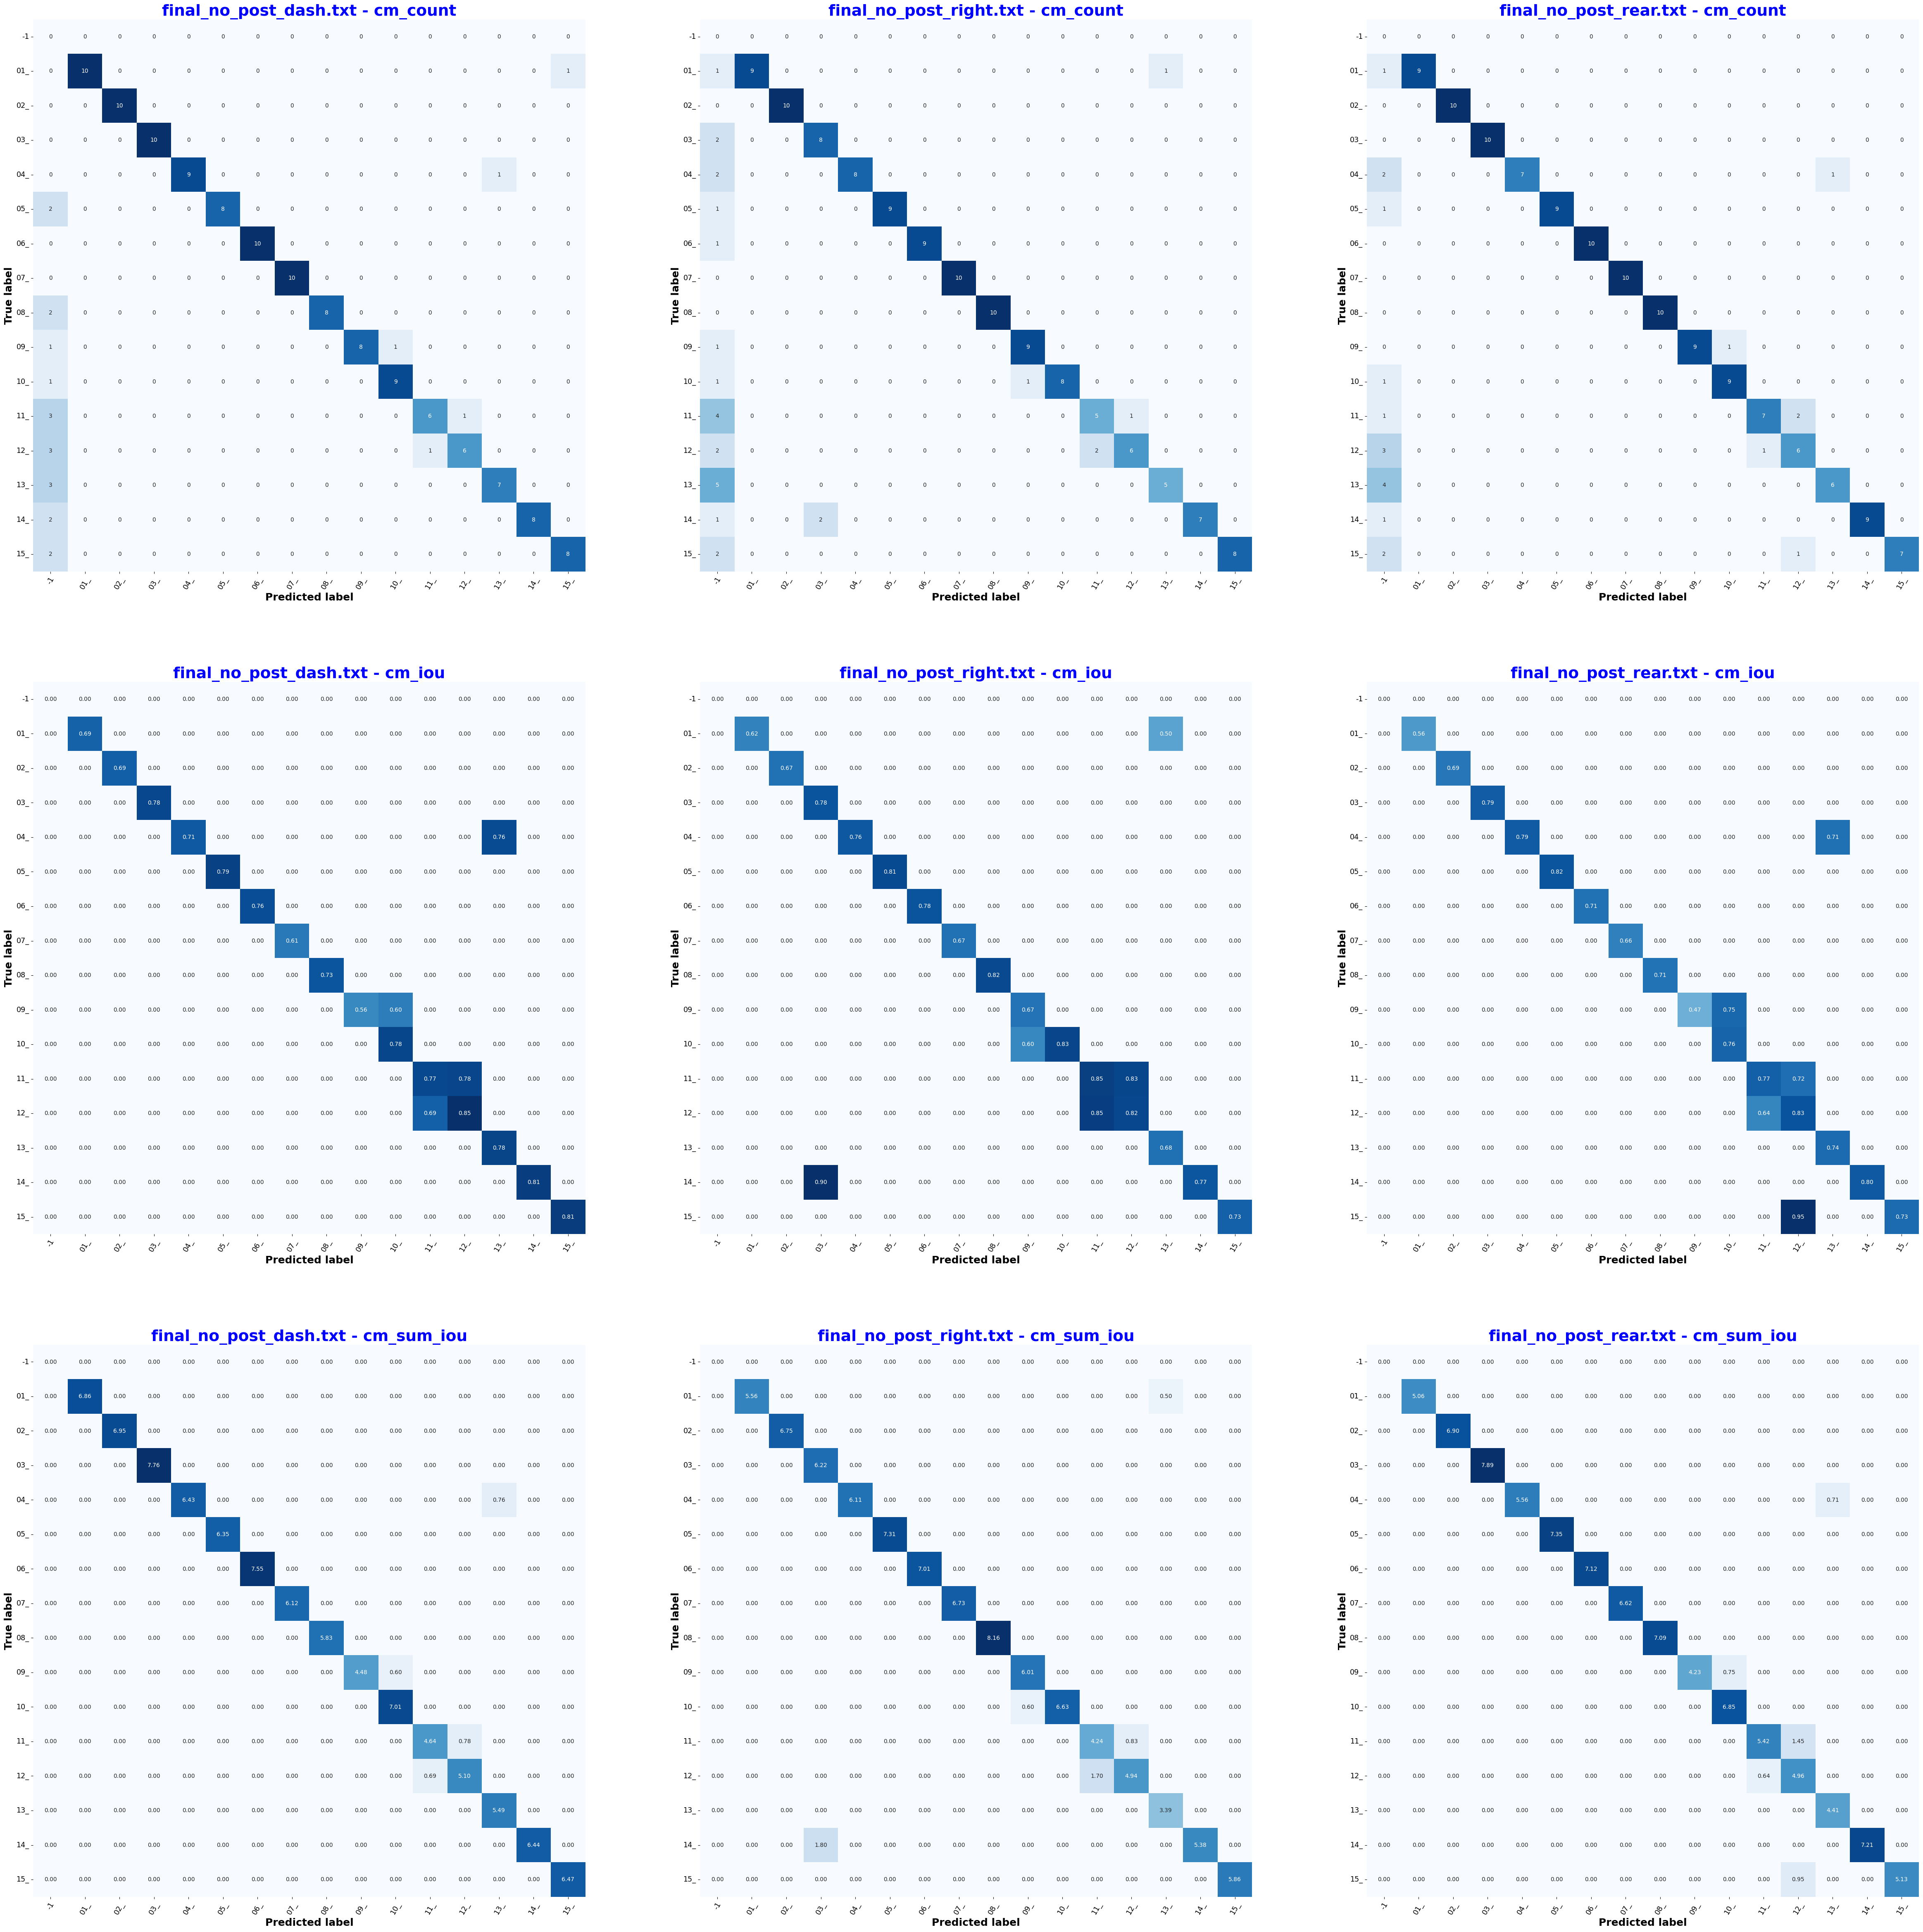

Ploting dict_keys(['action_iou', 'action_sum_iou']) metrics x 1 matrixes, transpose = False


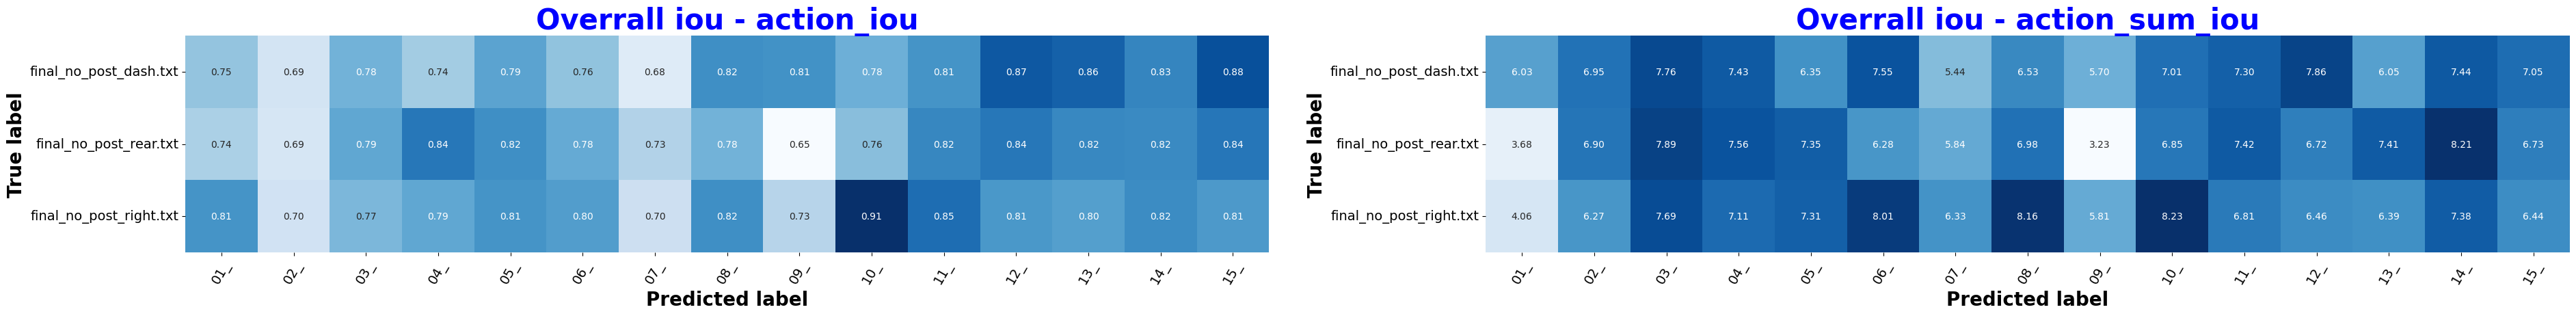

****************************************************************************************************
final_submission.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.7319503746234496
hit = 134 | count = 150 | hit/count = 0.8933333333333333


action_label,01_,02_,03_,04_,05_,06_,07_,08_,09_,10_,11_,12_,13_,14_,15_
iou,0.740635,0.694979,0.854043,0.73113,0.713531,0.776486,0.771642,0.741852,0.645403,0.812143,0.630315,0.601832,0.639389,0.837441,0.788435


Creating confusion matrix
Done
Ploting dict_keys(['cm_count', 'cm_iou', 'cm_sum_iou', 'action_iou', 'action_sum_iou']) metrics x 1 matrixes, transpose = False


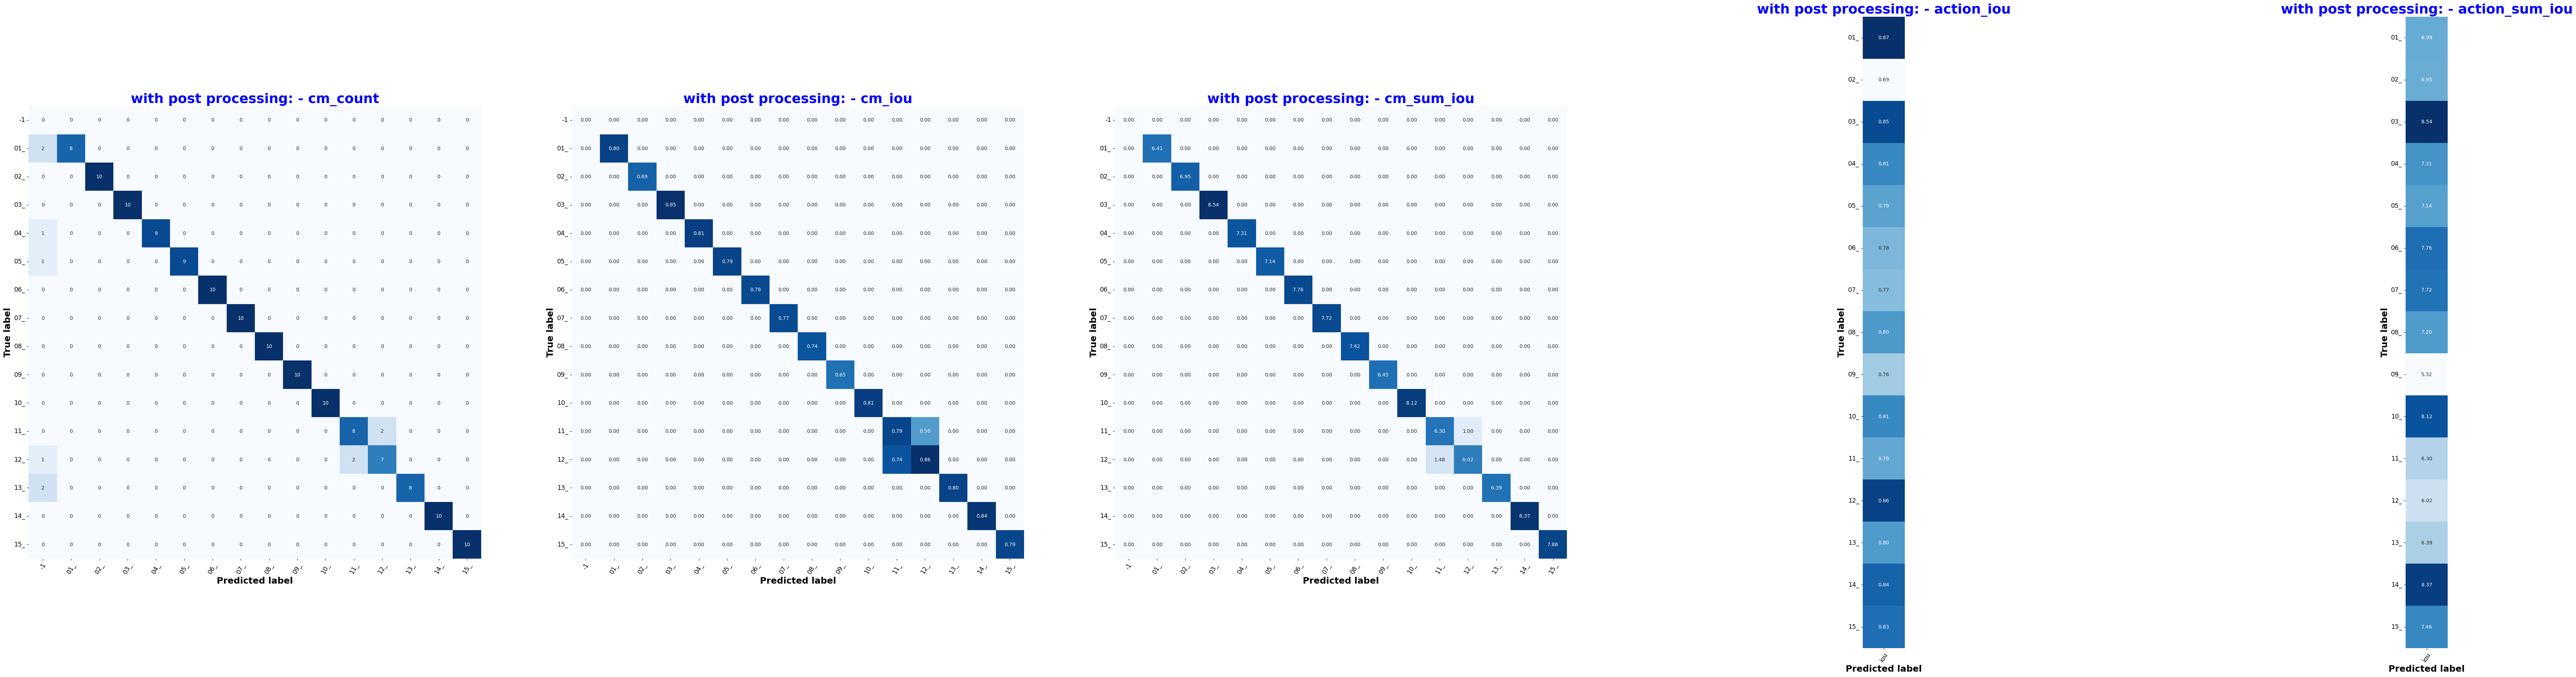

In [8]:

'''
    dict = {
        title1: {
            mretic1: cm,
            metric2: cm
        },
        title2: {
            mretic1: cm,
            metric2: cm
        },
    }
'''
temp1 = {}
temp2 = {}
df = pd.DataFrame()
df2 = pd.DataFrame()
for title, metrics in confusion_matrices_dict.items():
    temp1[title] = {'cm_count': metrics['cm_count'],
                    'cm_iou': metrics['cm_iou'],
                    'cm_sum_iou': metrics['cm_sum_iou']
                    }
    
    test_dict = {title:metrics['action_iou'].to_dict()['iou']}

    df = pd.concat([df,pd.DataFrame(test_dict)],axis=1)
    df2 = pd.concat([df2,pd.DataFrame({title:metrics['action_sum_iou'].to_dict()['iou']})],axis=1)
    # df = pd.concat([df,pd.DataFrame(metrics['action_iou'],index=title)],axis=1)
# display(df)
temp2['Overrall iou']={'action_iou':df.T,
                     'action_sum_iou':df2.T}
# plot_confusion_matrices(confusion_matrices_dict,transpose=True,size=18)

plot_confusion_matrices(temp1,transpose=True,size=18)

plot_confusion_matrices(temp2,transpose=False,size=20)

plot_confusion_matrices({"with post processing:":benchmark_submit(df_ground_truth,"final_submission.txt")},size=18)

In [9]:
temp2['Overrall iou']['action_sum_iou'].to_csv("custom_weight_sum_iou.csv")
temp2['Overrall iou']['action_iou'].to_csv("custom_weight_avg_iou.csv")

## try esemble by new weights

In [76]:
def multi_view_ensemble(avg_dash_seq, avg_right_seq, avg_rear_seq, mode='original',custom_weight_path = ''):
    '''
    Adds buffer to result and prioritizes result overall by view manually by granting higher weight.
    '''

    # Define weights for 
    # dashboard, right, and rear views
    weights = {
        'original': (0.3, 0.4, 0.3),
        'original_less_right': (0.4, 0.1, 0.4),
        'original_wo_buffer': (0.3, 0.4, 0.3),
        'rear': (0, 0, 1),
        'rear_wo_buffer': (0, 0, 1),
        'right': (0, 1, 0),
        'right_wo_buffer': (0, 1, 0),
        'dash': (1, 0, 0),
        'dash_wo_buffer': (1, 0, 0),
        'all_avg': (1/3,1/3,1/3),
        'all_avg_wo_buffer':(1/3,1/3,1/3),
        'custome':(0.3, 0.4, 0.3)

    }

    if mode not in weights:
        raise Exception("Invalid mode")

    alpha, beta, sigma = weights[mode]
    
    # Calculate the ensemble probability

    prob_ensemble = avg_dash_seq * alpha + avg_right_seq * beta + avg_rear_seq * sigma
    # prob_ensemble = (avg_dash_seq + avg_right_seq + avg_rear_seq)
    # Adjust the probabilities based on the mode
    if mode == 'custome':
        '''
            only apply weightage to non-normal activities
        '''
        assert custom_weight_path.endswith(".csv") , "weight path must be csv file"
        df_weight = pd.read_csv(custom_weight_path,header=0,index_col=0).T
        # display(df_weight)
        # df_weight.set_index(df_weight.columns[0],inplace=True)
        # df_weight.columns = df_weight.loc[0]
        # df_weight = df_weight[1:]
        # display(df_weight.loc['dash'][0])
        
        # print(df_weight.columns)
        # print(df_weight.index)
        # for action_id in df_weight.columns:
        #     for view in df_weight.index:
        #         prob_ensemble[:,action_id]=
        for idx, row in df_weight.iterrows():
            idx = int(idx)
            # print(f"idx: {idx}, row: {row}")
            # print("before: ",prob_ensemble[1,idx:idx+1])
            # print("dash",avg_dash_seq[1,idx:idx+1])
            # print("right",avg_right_seq[1,idx:idx+1])
            # print("rear", avg_rear_seq[1,idx:idx+1])
            '''
                
            '''
            prob_ensemble[:,idx:idx+1] = avg_dash_seq[:,idx:idx+1]*row['dash'] + avg_right_seq[:,idx:idx+1]*row['right']+ avg_rear_seq[:,idx:idx+1]*row['rear']
            # print("after: ",prob_ensemble[1,idx:idx+1])

    elif mode in ['original', 'original_wo_buffer','original_less_right']:
        prob_ensemble[:, 3:4] = avg_rear_seq[:, 3:4]
        prob_ensemble[:, 5:9] = avg_right_seq[:, 5:9]
        prob_ensemble[:, 13:14] = avg_dash_seq[:, 13:14]
        if mode in ['original','original_less_right']:
            prob_ensemble[:, 13:14] *= 2
            prob_ensemble[:, 14:] = avg_rear_seq[:, 14:]*1.5
        else:
            # original_wo_buffer
            prob_ensemble[:, 14:] = avg_right_seq[:, 14:]
    elif mode in ['rear', 'rear_wo_buffer']:
        prob_ensemble[:, 13:14] = avg_rear_seq[:, 13:14]
        prob_ensemble[:, 14:] = avg_rear_seq[:, 14:]
        if mode == 'rear':
            prob_ensemble[:, 13:14] *= 2
            prob_ensemble[:, 14:] *= 1.5
    elif mode in ['right', 'right_wo_buffer']:
        prob_ensemble[:, 13:14] = avg_right_seq[:, 13:14]
        prob_ensemble[:, 14:] = avg_right_seq[:, 14:]
        if mode == 'right':
            prob_ensemble[:, 13:14] *= 2
            prob_ensemble[:, 14:] *= 1.5
        # no else => do nothing = righ_wo_buffer
    elif mode in ['dash', 'dash_wo_buffer']:
        prob_ensemble[:, 13:14] = avg_dash_seq[:, 13:14]
        prob_ensemble[:, 14:] = avg_dash_seq[:, 14:]
        if mode == 'dash':
            prob_ensemble[:, 13:14] *= 2
            prob_ensemble[:, 14:] *= 1.5
        # no else => do nothing = dash_wo_buffer
    elif mode in ['all_avg']:
        if mode == 'all_avg':
            prob_ensemble[:, 13:14] *= 2
            prob_ensemble[:, 14:] *= 1.5
    # else all_avg_wo_buffer
    
    return prob_ensemble




from tools import util_loc
import re


'''
    weight format:
        {
            dash: [action0_weight,action1_weight,...,action15_weights],
            right: [action0_weight,action1_weight,...,action15_weights],
            rear: [action0_weight,action1_weight,...,action15_weights]
        }
'''
def run_submission(pickle_dir,output_name,mode='original',custom_weight_path = ''):
    '''
        1. load the view
        2. with every right_view prob
            2.1 find the dash_vd and rear_vd name
            2.2 with every element in pickcle result, create dictionary of video name with every view

    '''
    localization = []
    clip_classification = []
    # pickle_dir = "pickles/A2"
    # pickle_dir = "pickles/6_6_1_16_4_0.05_0.002_30"
    # pickle_dir = "pickles/author"
    # each view & fold will have pickel format: ['filename', 'clip_idx', "prob"]
    k_flod_dash_probs = load_k_fold_probs(pickle_dir, "dash")
    k_flod_right_probs = load_k_fold_probs(pickle_dir, "right")
    k_flod_rear_probs = load_k_fold_probs(pickle_dir, "rear")


    all_model_results = dict()
    print(k_flod_right_probs[0].keys())
    for right_vid in k_flod_right_probs[0].keys():
        dash_vid = "Dashboard_"+re.search("user_id_[0-9]{5}_NoAudio_[0-9]", right_vid)[0]
        rear_vid = "Rear_view_"+re.search("user_id_[0-9]{5}_NoAudio_[0-9]", right_vid)[0]

        '''
            dash_prob: {
                dash_vid: probs np.array of probs that vid
            }
        '''

        all_dash_probs = np.stack([np.array(list(map(np.array, dash_prob[dash_vid]))) for dash_prob in k_flod_dash_probs])
        all_right_probs = np.stack([np.array(list(map(np.array, right_prob[right_vid]))) for right_prob in k_flod_right_probs])
        all_rear_probs = np.stack([np.array(list(map(np.array, rear_prob[rear_vid]))) for rear_prob in k_flod_rear_probs])

        # avg all fold
        avg_dash_seq = np.mean(all_dash_probs, axis=0)
        avg_right_seq = np.mean(all_right_probs, axis=0)
        avg_rear_seq = np.mean(all_rear_probs, axis=0)

        # avg_dash_seq = np.max(all_dash_probs, axis=0)
        # avg_right_seq = np.max(all_right_probs, axis=0)
        # avg_rear_seq = np.max(all_rear_probs, axis=0)

        avg_dash_seq = smoothing(np.array(avg_dash_seq), k=1)
        avg_right_seq = smoothing(np.array(avg_right_seq), k=1)
        avg_rear_seq = smoothing(np.array(avg_rear_seq), k=1)

        # handle when multiple view can have diferrent duration -> get min duration
        length = min(avg_dash_seq.shape[0], avg_right_seq.shape[0], avg_rear_seq.shape[0])
        avg_dash_seq, avg_right_seq, avg_rear_seq = avg_dash_seq[:length, :],avg_right_seq[:length, :],avg_rear_seq[:length, :]

        prob_ensemble = multi_view_ensemble(avg_dash_seq, avg_right_seq, avg_rear_seq,mode = mode,custom_weight_path=custom_weight_path)
        # break
        vid = _FILENAME_TO_ID[right_vid]
        prob_seq = np.array(prob_ensemble)
        prob_seq = np.squeeze(prob_seq)
        clip_classification += activity_localization(prob_seq, vid, 0.1)

        all_model_results[vid] = {
            "dash":all_dash_probs,
            "rear":all_rear_probs,
            "right":all_right_probs
        }
        # print(clip_classification)

    clip_classification = pd.DataFrame(clip_classification, columns=["video_id", "label", "start", "end"])
    loc_segments = util_loc.clip_to_segment(clip_classification)
    loc_segments = util_loc.reclassify_segment(loc_segments, all_model_results)
    loc_segments =  util_loc.correct_with_prior_constraints(loc_segments)
    with open(output_name, "w") as fp:
        # for (vid, label, start, end) in loc_segments.values.tolist():
        for (vid, label, start, end) in loc_segments:
            fp.writelines("{} {} {} {}\n".format(int(vid), label, start, end))   
    return loc_segments
results = {"with post processing:":benchmark_submit(df_ground_truth,"final_submission.txt")}
pickle_dir = "pickles/author"
# weights by avg iou
weight_path = "custom_weight_avg_iou.csv"
output_filename ="final_"+weight_path.replace(".csv","") +".csv"
print("output_name:",output_filename)
submit = run_submission(pickle_dir=pickle_dir,mode='custome',custom_weight_path=weight_path,output_name=output_filename)
results[output_filename] = benchmark_submit(df_ground_truth=df_ground_truth,csv_file_path=output_filename)
# weights by sum_iou
weight_path = "custom_weight_sum_iou.csv"
output_filename ="final_"+weight_path.replace(".csv","") +".csv"
print("output_name:",output_filename)
submit = run_submission(pickle_dir=pickle_dir,mode='custome',custom_weight_path=weight_path,output_name=output_filename)
results[output_filename] = benchmark_submit(df_ground_truth=df_ground_truth,csv_file_path=output_filename)
plot_confusion_matrices(results,transpose=True)

****************************************************************************************************
final_submission.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou with correct action_id:  0.7319503746234496
hit = 134 | count = 150 | hit/count = 0.8933333333333333


action_label,01_,02_,03_,04_,05_,06_,07_,08_,09_,10_,11_,12_,13_,14_,15_
iou,0.740635,0.694979,0.854043,0.73113,0.713531,0.776486,0.771642,0.741852,0.645403,0.812143,0.630315,0.601832,0.639389,0.837441,0.788435


Creating confusion matrix
Done
output_name: final_custom_weight_avg_iou.csv
dict_keys(['Right_side_window_user_id_26223_NoAudio_3', 'Right_side_window_user_id_26223_NoAudio_5', 'Right_side_window_user_id_42897_NoAudio_5', 'Right_side_window_user_id_42897_NoAudio_7', 'Right_side_window_user_id_49989_NoAudio_5', 'Right_side_window_user_id_49989_NoAudio_7', 'Right_side_window_user_id_51953_NoAudio_3', 'Right_side_window_user_id_51953_NoAudio_7', 'Right_side_window_user_id_96715_NoAudio_5', 'Right_side_window_user_id_96715_NoAudio_7'])
2 does not have 12
3 does not have 13
3 does not have 14
4 does not have 13
5 does not have 11
6 does not have 13
7 does not have 11
8 does not have 15
9 does not have 4
10 does not have 8
****************************************************************************************************
final_custom_weight_avg_iou.csv
****************************************************************************************************
calculated result vs ground truth:
avg 

action_label,01_,02_,03_,04_,05_,06_,07_,08_,09_,10_,11_,12_,13_,14_,15_
iou,0.740635,0.694979,0.845861,0.721606,0.713977,0.77115,0.740128,0.693323,0.66707,0.786169,0.622623,0.597986,0.770714,0.758235,0.820024


Creating confusion matrix
Done
output_name: final_custom_weight_sum_iou.csv
dict_keys(['Right_side_window_user_id_26223_NoAudio_3', 'Right_side_window_user_id_26223_NoAudio_5', 'Right_side_window_user_id_42897_NoAudio_5', 'Right_side_window_user_id_42897_NoAudio_7', 'Right_side_window_user_id_49989_NoAudio_5', 'Right_side_window_user_id_49989_NoAudio_7', 'Right_side_window_user_id_51953_NoAudio_3', 'Right_side_window_user_id_51953_NoAudio_7', 'Right_side_window_user_id_96715_NoAudio_5', 'Right_side_window_user_id_96715_NoAudio_7'])
2 does not have 12
3 does not have 13
3 does not have 14
4 does not have 13
5 does not have 11
6 does not have 13
7 does not have 11
8 does not have 15
9 does not have 4
10 does not have 8
****************************************************************************************************
final_custom_weight_sum_iou.csv
****************************************************************************************************
calculated result vs ground truth:
avg 

action_label,01_,02_,03_,04_,05_,06_,07_,08_,09_,10_,11_,12_,13_,14_,15_
iou,0.740635,0.694979,0.845861,0.724939,0.713977,0.77115,0.760128,0.682609,0.66707,0.786169,0.622623,0.597986,0.770714,0.758235,0.820024


Creating confusion matrix
Done
Ploting dict_keys(['cm_count', 'cm_iou', 'cm_sum_iou', 'action_iou', 'action_sum_iou']) metrics x 3 matrixes, transpose = True
